# Late Fusion Project

Before we start, acknowledgement to this repo: https://github.com/kuixu/kitti_object_vis.

We'll use the [KITTI Dataset](http://www.cvlibs.net/datasets/kitti/setup.php) to collect the Point Clouds, Images, and Calibration parameters. <p>

After loading data from the dataset, our Late fusion process will happen in 5 steps:
1.   **Detect Obstacles in 2D** with the Camera
2.   **Detect Obstacles in 3D** with the LiDAR
3.   **Project the 3D Obstacles** in the Image (3D Bounding Boxes)
4.   **Fuse the 3D Bounding Box (LiDAR) with the 2D Bounding Box (Camera)**
5.   **Create a Fused Object** and Show the results






In [1]:
# mount
from google.colab import drive
drive.mount('/content/drive')

# os.chdir to current notebook's path after mounting
import os
os.chdir("/content/drive/MyDrive/Visual_Fusion/VS_repo")

# check contents
!ls #Project_a_3D_point_to_2D.ipynb => verified

!scp -r ./data ../visual_fusion_gt #Learning !<treat as cmd line in Colab>



Mounted at /content/drive
'Copy of Visual_Fusion_Late.ipynb'   out.mp4			        video1_clip10.mp4
 data				     pc_image_correspondence	        video.mp4
 Late_Fusion_from_Scratch.ipynb      point_clouds		        YOLO
 lidar_bboxes.png		     Project_a_3D_point_to_2D_1.ipynb
 out.avi			     Project_a_3D_point_to_2D.ipynb


## Read the files

* data folder contents
  - calib    (contains text files) -> transform matrices , P, R0, Rt
  - img      (contains png) -> can vizualise using mpimg
  - label
  - velodyne (contains pcd) -> vizualise using pypotree and open3d

In [2]:
!pip install pypotree # for viz pc on Colab
!pip install open3d # builds the cloud_obj which has points as attributes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pypotree: filename=pypotree-1.0.5-py3-none-any.whl size=10299241 sha256=752cc4b697ca8077191841c5b2ec300fd3f8a0f019d4c9764ad1b88342913c36
  Stored in directory: /root/.cache/pip/wheels/61/53/c5/9fa90014fa2b468849fcebd5b3bb71f8eda71229e9953a6c5b
Successfully built pypotree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsn

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import open3d as o3d
import numpy as np
import glob
import pypotree

* Build the files

In [4]:
calib_files = glob.glob("./data/calib/*.txt")
img_files = glob.glob("./data/img/*.png")
point_files = glob.glob("./data/velodyne/*.pcd")
label_files = glob.glob("./data/label/*.txt")


# listify and sort
calib_files = sorted(list(calib_files))
img_files = sorted(list(img_files))
point_files = sorted(list(point_files))
label_files = sorted(list(label_files))


## Sanity Check on these files

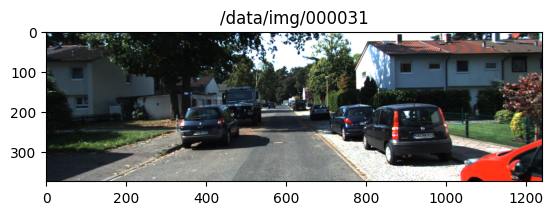

In [5]:
def viz_image_in_grid(img_path):
  img = mpimg.imread(img_path)
  filename = img_path.split(".")[-2]  #'./data/img/000031.png'
  f, ax = plt.subplots(nrows = 1, ncols = 1)
  ax.imshow(img) #ax.imshow(img)
  ax.set_title( str(filename) )
  return


idx = 0
# print( len(img_files), img_files )
img_path = img_files[0]
viz_image_in_grid(img_path)


In [6]:
def get_points_asnp(point_file):
  '''
    - Using o3d.io.read_point_clouds(file) -> point_obj
    - points attr from point_obj
    - numpify and return
  '''
  point_obj = o3d.io.read_point_cloud(point_file)
  points = point_obj.points
  # print( type(points) ) #<class 'open3d.cpu.pybind.utility.Vector3dVector'>

  points = np.asarray(points)
  return points






idx = 0
point_file = point_files[idx]
points = get_points_asnp(point_file)

# viz_point_cloud(points)

print(points.shape) #(121291, 3)
path = pypotree.generate_cloud_for_display(points)
print(type(path), path)
pypotree.display_cloud_colab(path)


Output hidden; open in https://colab.research.google.com to view.

## Create a Lidar2Cam class
- Use the transformations to transform the point-cloud
from velodyne space to pixel space
- Also, take care of the Euclidean to Homo transformation
- Verify using pypotree the location of point-cloud coords and the one in the pixel space of a particular car

** The intitial shapes of the tansformation matrices

The main formula we'll use will be as follows:<p>
**Y(2D) = P x R0 x R|t x X (3D)**

However, when looking at the dimensions:

*   P: [3x4]
*   R0: [3x3]
*   R|t = Velo2Cam: [3x4]
*   X: [3x1]

We'll need to convert some points into Homogeneous Coordinates:
* RO must go from 3x3 to 4x3
* x must go from 3x1 to 4x1

Then, to retrieve the cartesian system, we'll divide.

In [7]:
class LiDAR2Cam(object):
  def __init__(self, calib_file):

    # init the matrices
    # intrinsic matrix
    print(calib_file)
    calibs = self.read_calib_file(calib_file)

    self.P0 = calibs["P2"]
    self.P0 = np.reshape( self.P0, [3, 4] )

    # stereo matrix
    self.R0 = calibs["R0_rect"]
    self.R0 = np.reshape( self.R0, [3, 3] )


    # extrinsic matrix
    self.Rt = calibs["Tr_velo_to_cam"]
    self.Rt = np.reshape( self.Rt, [3, 4] )

    print( self.R0.shape, self.Rt.shape, self.P0.shape )


    # To be transformed
    self.P0_homo, self.R0_homo, self.Rt_homo = self.P0, self.R0, self.Rt
    self.set_matrices_from_euclidean_to_homo()
    print( self.R0_homo.shape, self.Rt_homo.shape, self.P0_homo.shape )



  def set_matrices_from_euclidean_to_homo(self):
    '''
      Just modifies the P0, R0, and Rt matrices to desirable coord-sys
    '''
    # Imnagine interaction with homo coords
    # [x y z 1]
    # Rt has shape (3, 4) -> (4, 4)
    self.Rt_homo = np.vstack( [self.Rt, [0, 0, 0, 1]] )

    self.R0_homo = np.column_stack( [self.R0, [0, 0, 0]] )
    self.R0_homo = np.vstack( [self.R0_homo, [0, 0, 0, 1]] )

    self.P0_homo = np.vstack( [self.P0, [0, 0, 0, 1]] )
    return

  def get_points_from_euclidean_to_homo(self, points):
    '''
      ( x, y, z) -> (x, y, z, 1)
      print(points.shape) #(121291, 3) as seen above
      Need to make it points have to be column vectors
    '''
    points_homo = np.transpose(points)
    # print( points_homo.shape )

    # (x, y, z) as column view -> make column (x, y, z, 1) for each point
    num_points = points_homo.shape[1]
    points_homo = np.vstack( [points_homo, np.ones(num_points) ] )
    return points_homo

  def project_from_velo_to_pixel_space(self, points):
    points_homo = self.get_points_from_euclidean_to_homo(points)

    points_extrinsic_space = np.dot( self.Rt_homo, points_homo )
    rectified_points = np.dot( self.R0_homo, points_extrinsic_space )

    pts_2d = np.dot( self.P0, rectified_points )

    # actual values are [x, y, k] -> [x/k, y/k, 1] in pixel space[ euclidean ]
    # print( pts_2d.shape )

    pts_2d[0, :] /= pts_2d[2, :]
    pts_2d[1, :] /= pts_2d[2, :]

    # print( pts_2d[:, 0] ) # [526.23638509 146.95787607  21.49066856]

    pts_2d = np.transpose( pts_2d )

    return pts_2d[:, 0:2], points[:, :]




  def read_calib_file(self, filepath):
      """ Read in a calibration file and parse into a dictionary.
      Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
      """
      data = {}
      with open(filepath, "r") as f:
          for line in f.readlines():
              line = line.rstrip()
              if len(line) == 0:
                  continue
              key, value = line.split(":", 1)
              # The only non-float values in these files are dates, which
              # we don't care about anyway
              try:
                  data[key] = np.array([float(x) for x in value.split()])
              except ValueError:
                  pass
      return data


idx = 0
lidar2cam = LiDAR2Cam(calib_files[idx])

point_file = point_files[idx]
points = get_points_asnp(point_file)

velo_space_coords, pixel_space_coords = lidar2cam.project_from_velo_to_pixel_space(points)
print( velo_space_coords[0] )
print()
print( pixel_space_coords[0] )



./data/calib/000031.txt
(3, 3) (3, 4) (3, 4)
(4, 4) (4, 4) (4, 4)
[526.23638509 146.95787607]

[21.75099945  2.53399992  0.94999999]


## Sanity Check on image and Pypotree visualisations

In [ ]:
# Verified!
# [526.23638509 146.95787607  21.49066856] -> image coords
# [21.75099945  2.53399992  0.94999999] -> velo coords as shown in pypotree

## Get the Velodyne Coords in the Image Field of View

In [8]:
def get_lidar_in_image_fov(self,pc_velo, xmin, ymin, xmax, ymax, return_more=False, clip_distance=2.0):
    """ Filter lidar points, keep those in image FOV """
    pts_2d, points = self.project_from_velo_to_pixel_space(pc_velo)
    # print( type(pts_2d) )
    # print( pts_2d.shape )

    fov_inds = (
        (pts_2d[:, 0] < xmax)
        & (pts_2d[:, 0] >= xmin)
        & (pts_2d[:, 1] < ymax)
        & (pts_2d[:, 1] >= ymin)
    )
    fov_inds = fov_inds & (pc_velo[:, 0] > clip_distance) # We don't want things that are closer to the clip distance (2m)
    imgfov_pc_velo = pc_velo[fov_inds, :]
    if return_more:
        return imgfov_pc_velo, pts_2d, fov_inds
    else:
        return imgfov_pc_velo

LiDAR2Cam.get_lidar_in_image_fov = get_lidar_in_image_fov

## Get the LiDAR coords and overlay them

In [9]:
def show_lidar_on_image(self, pc_velo, img, debug="False", clip_distance=20.0, point_size=2):
    """ Project LiDAR points to image """
    imgfov_pc_velo, pts_2d, fov_inds = self.get_lidar_in_image_fov(
        pc_velo, 0, 0, img.shape[1], img.shape[0], return_more=True, clip_distance=clip_distance
    )


    if (debug==True):
        print("3D PC Velo "+ str(imgfov_pc_velo)) # The 3D point Cloud Coordinates
        print("2D PIXEL: " + str(pts_2d)) # The 2D Pixels
        print("FOV : "+str(fov_inds)) # Whether the Pixel is in the image or not
    self.imgfov_pts_2d = pts_2d[fov_inds, :]

    # Create a color - map to map depth i.e imgfov_pc_velo[i, 0] {depth} to a color
    # for clip distance = 2 => 510/2.0 , for > 20.0 => 510 / (>2.0) => < 255.0
    # To make it more generic
      # 255*clip_distance / ( depth{>clip_distance} ) -> within [0, 255.0]

    cmap = plt.cm.get_cmap("hsv", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
    self.imgfov_pc_velo = imgfov_pc_velo

    for i in range(self.imgfov_pts_2d.shape[0]):
        #depth = self.imgfov_pc_rect[i,2]
        #print(depth)
        depth = imgfov_pc_velo[i,0]
        #print(depth)
        MAX = 255.0 * clip_distance
        color = cmap[int(MAX / depth), :]
        cv2.circle(
            img,(int(np.round(self.imgfov_pts_2d[i, 0])), int(np.round(self.imgfov_pts_2d[i, 1]))),point_size,
            color=tuple(color),
            thickness=-1,
        )

    return img

LiDAR2Cam.show_lidar_on_image = show_lidar_on_image

In [10]:
idx = 0
img_path = img_files[idx]
import cv2

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
# img = mpimg.imread(img_path)
print(img.shape)
xmin, xmax, ymin, ymax = 0, img.shape[1], 0, img.shape[0]


(375, 1242, 3)


#### Verify for a single point with varying clip_distances

<ipython-input-9-58d95e7d9119>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)
::ffff:127.0.0.1 - - [16/May/2024 04:02:16] "GET /point_clouds/libs/openlayers3/ol.css HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:16] "GET /point_clouds/libs/perfect-scrollbar/css/perfect-scrollbar.css HTTP/1.1" 200 -


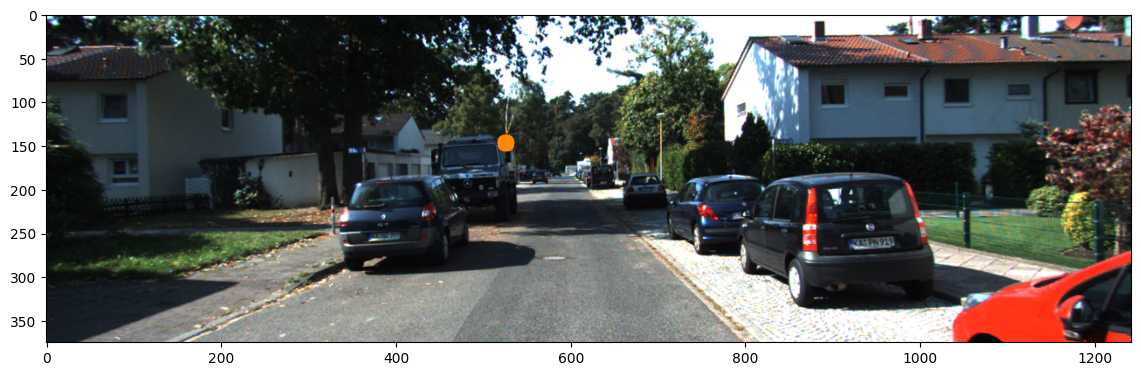

In [11]:
img_3 = img.copy()
img_3 = lidar2cam.show_lidar_on_image(points[0:1,:3], img_3, clip_distance=2.0, point_size=10)
plt.figure(figsize=(14,7))
plt.imshow(img_3)
plt.show()

<ipython-input-9-58d95e7d9119>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)
::ffff:127.0.0.1 - - [16/May/2024 04:02:16] "GET /point_clouds/libs/spectrum/spectrum.css HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:16] "GET /point_clouds/libs/jstree/themes/mixed/style.css HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:17] "GET /point_clouds/libs/jquery/jquery-3.1.1.min.js HTTP/1.1" 200 -


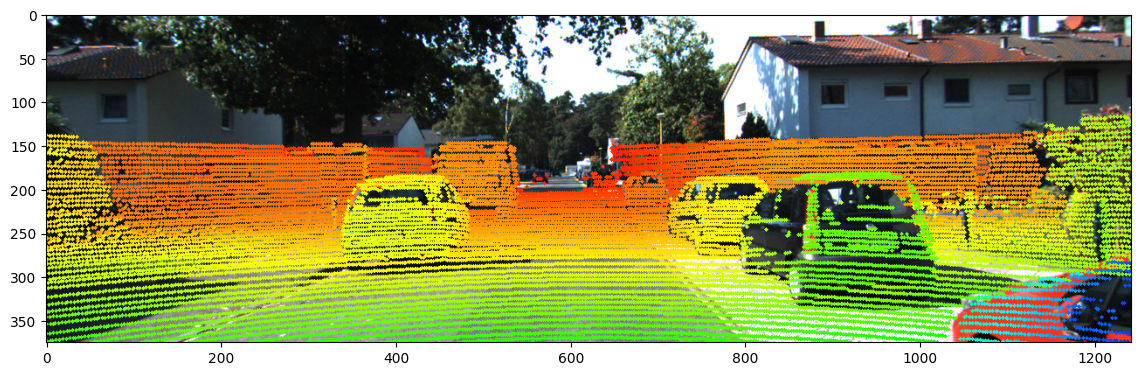

In [12]:
img_3 = img.copy()
img_3 = lidar2cam.show_lidar_on_image(points[:,:3], img_3, clip_distance=2.0)
plt.figure(figsize=(14,7))
plt.imshow(img_3)
plt.show()

<ipython-input-9-58d95e7d9119>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)


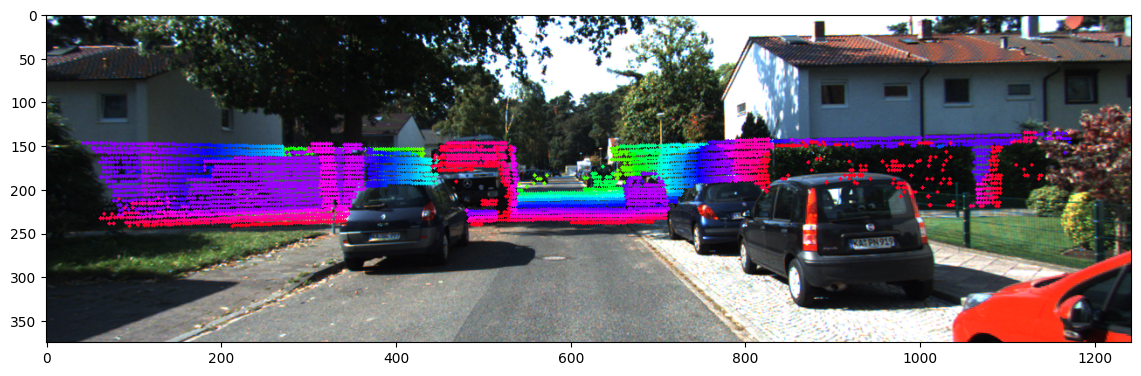

In [13]:
img_3 = img.copy()
img_3 = lidar2cam.show_lidar_on_image(points[:,:3], img_3, clip_distance=20.0)
plt.figure(figsize=(14,7))
plt.imshow(img_3)
plt.show()

#### Get a Video after processing each frame

## Object Detection in 2D

In [14]:
!python3 -m pip install yolov4==2.0.2 # After Checking, YOLO 2.0.2 works without modifying anything. Otherwise keep 1.2.1

::ffff:127.0.0.1 - - [16/May/2024 04:02:18] "GET /point_clouds/libs/spectrum/spectrum.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:20] "GET /point_clouds/libs/perfect-scrollbar/js/perfect-scrollbar.jquery.js HTTP/1.1" 200 -


::ffff:127.0.0.1 - - [16/May/2024 04:02:21] "GET /point_clouds/libs/jquery-ui/jquery-ui.min.js HTTP/1.1" 200 -


  Preparing metadata (setup.py) ... done


::ffff:127.0.0.1 - - [16/May/2024 04:02:23] "GET /point_clouds/libs/three.js/build/three.min.js HTTP/1.1" 200 -


  Created wheel for yolov4: filename=yolov4-2.0.2-py3-none-any.whl size=39741 sha256=80410b5c48cbe5c0fb686b576c0c6715625dff477a694ddc55dd308a8bcceff8
  Stored in directory: /root/.cache/pip/wheels/55/32/e0/b3cc98a6ab4a0a583ce2572baf44ef09172ed74e61dbfddc26
Successfully built yolov4


::ffff:127.0.0.1 - - [16/May/2024 04:02:25] "GET /point_clouds/libs/other/BinaryHeap.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:26] "GET /point_clouds/libs/tween/tween.min.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:26] "GET /point_clouds/libs/d3/d3.js HTTP/1.1" 200 -


::ffff:127.0.0.1 - - [16/May/2024 04:02:28] "GET /point_clouds/libs/proj4/proj4.js HTTP/1.1" 200 -


::ffff:127.0.0.1 - - [16/May/2024 04:02:30] "GET /point_clouds/libs/openlayers3/ol.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:32] "GET /point_clouds/libs/i18next/i18next.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:33] "GET /point_clouds/libs/jstree/jstree.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:35] "GET /point_clouds/libs/potree/potree.colab.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:38] "GET /point_clouds/libs/plasio/js/laslaz.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:39] "GET /point_clouds/pointclouds/60a12e/cloud.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:39] "GET /point_clouds/libs/potree/resources/icons/close.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:39] "GET /point_clouds/libs/potree/resources/icons/eye_2.png HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:39] "GET /point_clouds/libs/potree/sidebar.html HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:0

1/1 [==============================] - 2s 2s/step


::ffff:127.0.0.1 - - [16/May/2024 04:02:43] "GET /point_clouds/libs/potree/resources/icons/point.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:43] "GET /point_clouds/libs/potree/resources/icons/distance.svg HTTP/1.1" 200 -


[[0.62174082 0.53655535 0.06932729 0.07417393 2.         0.89790833]
 [0.72870779 0.55725408 0.18343693 0.13454075 2.         0.76024503]
 [0.32518396 0.5429889  0.11372865 0.08993029 2.         0.74988025]
 [0.39092571 0.49559131 0.06420012 0.07433805 7.         0.43251917]]
[[0.62174082 0.53655535 0.06932729 0.07417393 2.         0.89790833]
 [0.72870779 0.55725408 0.18343693 0.13454075 2.         0.76024503]
 [0.32518396 0.5429889  0.11372865 0.08993029 2.         0.74988025]
 [0.39092571 0.49559131 0.06420012 0.07433805 7.         0.43251917]]
[[0.62174082 0.62107132 0.06932729 0.24566407 2.         0.89790833]
 [0.72870779 0.6896255  0.18343693 0.44559897 2.         0.76024503]
 [0.32518396 0.64237922 0.11372865 0.29784912 2.         0.74988025]
 [0.39092571 0.48539843 0.06420012 0.24620762 7.         0.43251917]]
Original Image Shape:  (375, 1242, 3)
Resulting Image Shape:  (375, 1242, 3)
Predicted BBoxes Shape:  (4, 6)
[[0.62174082 0.62107132 0.06932729 0.24566407 2.         0.8

::ffff:127.0.0.1 - - [16/May/2024 04:02:44] "GET /point_clouds/libs/potree/resources/icons/height.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:44] "GET /point_clouds/libs/potree/resources/icons/area.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:44] "GET /point_clouds/libs/potree/resources/icons/volume.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:45] "GET /point_clouds/libs/potree/resources/icons/profile.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:45] "GET /point_clouds/libs/potree/resources/icons/reset_tools.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:45] "GET /point_clouds/libs/potree/resources/icons/file_geojson.svg HTTP/1.1" 200 -


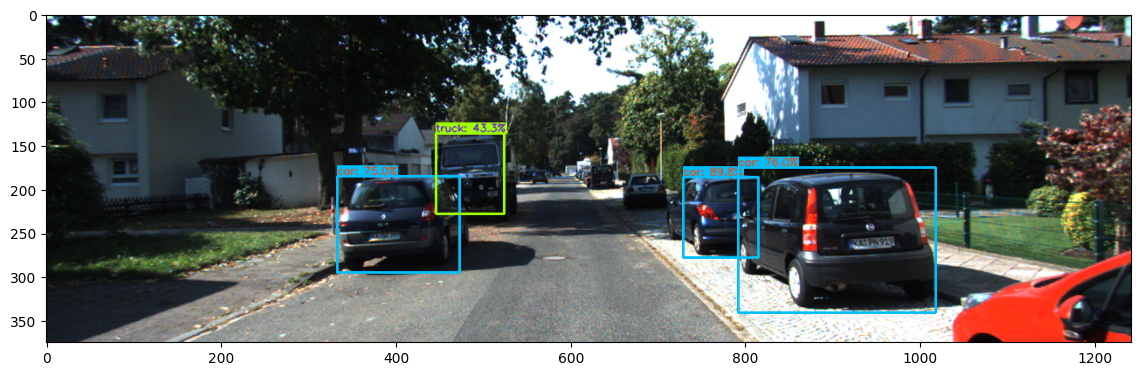

In [15]:
from yolov4.tf import YOLOv4
import tensorflow as tf
import time
import cv2

yolo = YOLOv4(tiny=True)
yolo.classes = "YOLO/coco.names"
yolo.make_model()
yolo.load_weights("YOLO/yolov4-tiny.weights", weights_type="yolo")

idx = 0
img_path = img_files[idx]
image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

from yolov4.tf import YOLOv4
import tensorflow as tf
import time

yolo = YOLOv4(tiny=True)
yolo.classes = "YOLO/coco.names"
yolo.make_model()
yolo.load_weights("YOLO/yolov4-tiny.weights", weights_type="yolo")

def run_obstacle_detection(img):
    start_time=time.time()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = yolo.resize_image(img)
    # 0 ~ 255 to 0.0 ~ 1.0
    resized_image = resized_image / 255.
    #input_data == Dim(1, input_size, input_size, channels)
    input_data = resized_image[np.newaxis, ...].astype(np.float32)

    candidates = yolo.model.predict(input_data)

    _candidates = []
    result = img.copy()
    for candidate in candidates:
        batch_size = candidate.shape[0]
        grid_size = candidate.shape[1]
        _candidates.append(tf.reshape(candidate, shape=(1, grid_size * grid_size * 3, -1)))
        #candidates == Dim(batch, candidates, (bbox))
        candidates = np.concatenate(_candidates, axis=1)
        #pred_bboxes == Dim(candidates, (x, y, w, h, class_id, prob))
        pred_bboxes = yolo.candidates_to_pred_bboxes(candidates[0], iou_threshold=0.35, score_threshold=0.40)
        print( pred_bboxes )

        pred_bboxes = pred_bboxes[~(pred_bboxes==0).all(1)] #https://stackoverflow.com/questions/35673095/python-how-to-eliminate-all-the-zero-rows-from-a-matrix-in-numpy?lq=1
        print( pred_bboxes )

        pred_bboxes = yolo.fit_pred_bboxes_to_original(pred_bboxes, img.shape)
        print( pred_bboxes )

        exec_time = time.time() - start_time
        #print("time: {:.2f} ms".format(exec_time * 1000))
        result = yolo.draw_bboxes(img, pred_bboxes)
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

        return result, pred_bboxes
    return result, pred_bboxes

result, pred_bboxes = run_obstacle_detection(image)

print( "Original Image Shape: ", image.shape )
print( "Resulting Image Shape: ", result.shape )
print( "Predicted BBoxes Shape: ", pred_bboxes.shape )
print( pred_bboxes)

fig_camera = plt.figure(figsize=(14, 7))
ax_lidar = fig_camera.subplots()
ax_lidar.imshow(result)
plt.show()

::ffff:127.0.0.1 - - [16/May/2024 04:02:46] "GET /point_clouds/libs/potree/resources/icons/file_dxf.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:46] "GET /point_clouds/libs/potree/resources/icons/earth_controls_1.png HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:46] "GET /point_clouds/libs/potree/resources/icons/fps_controls.svg HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [16/May/2024 04:02:46] "GET /point_clouds/libs/potree/resources/icons/helicopter_controls.svg HTTP/1.1" 200 -


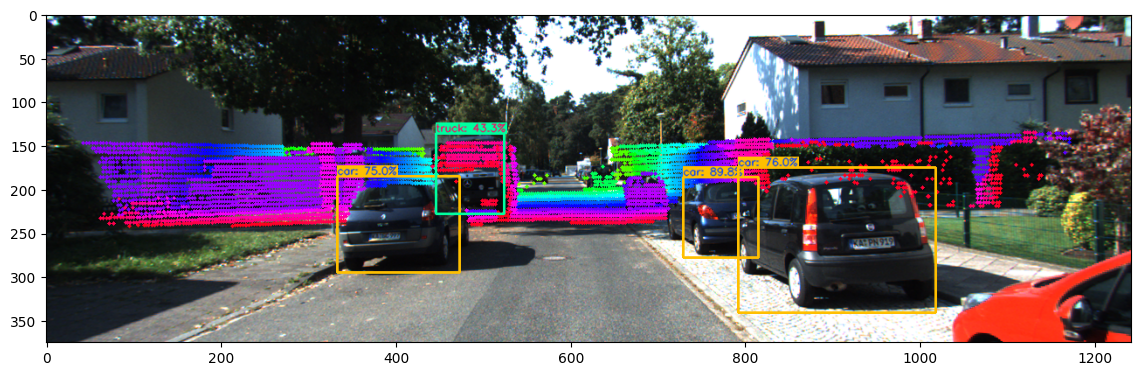

In [16]:
lidar_img_with_bboxes= yolo.draw_bboxes(img_3, pred_bboxes)
fig_fusion = plt.figure(figsize=(14, 7))
ax_fusion = fig_fusion.subplots()
ax_fusion.imshow(lidar_img_with_bboxes)
plt.show()
# cv2.imwrite("lidar_bboxes.png", lidar_img_with_bboxes)